In [1]:
%matplotlib inline
import pandas as pd
import datetime
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib.pylab import style
from fbprophet import Prophet
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
 
import pymysql as sql
import datetime

get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 15,8
#from pyecharts import Line

#不输出警告
import warnings
warnings.filterwarnings("ignore")
import time

style.use('ggplot')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

## 1.原始数据

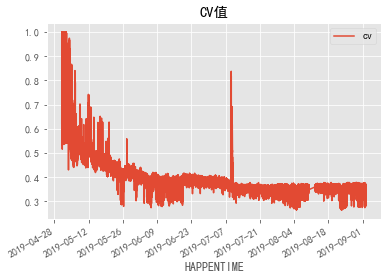

In [2]:
path=r'.\\data\\door1_close_cv_0902.csv'
door_df = pd.read_csv(path,index_col='HAPPENTIME', parse_dates=True)
door_df = door_df['2019-05-1':]
# df['y']=np.log(df['y'])# tricks
door_df.plot(title='CV值')
door_df=door_df['cv'].resample("1H").mean()   
door_df=door_df.fillna(method="ffill")
# ix=list(door_df.index)
# plt.annotate('open',xy=(ix.index(pd.to_datetime('2019-08-10')),0.8),arrowprops = dict(facecolor='red',shrink=0.1))   
# ax=door_df.plot()

### 2 训练

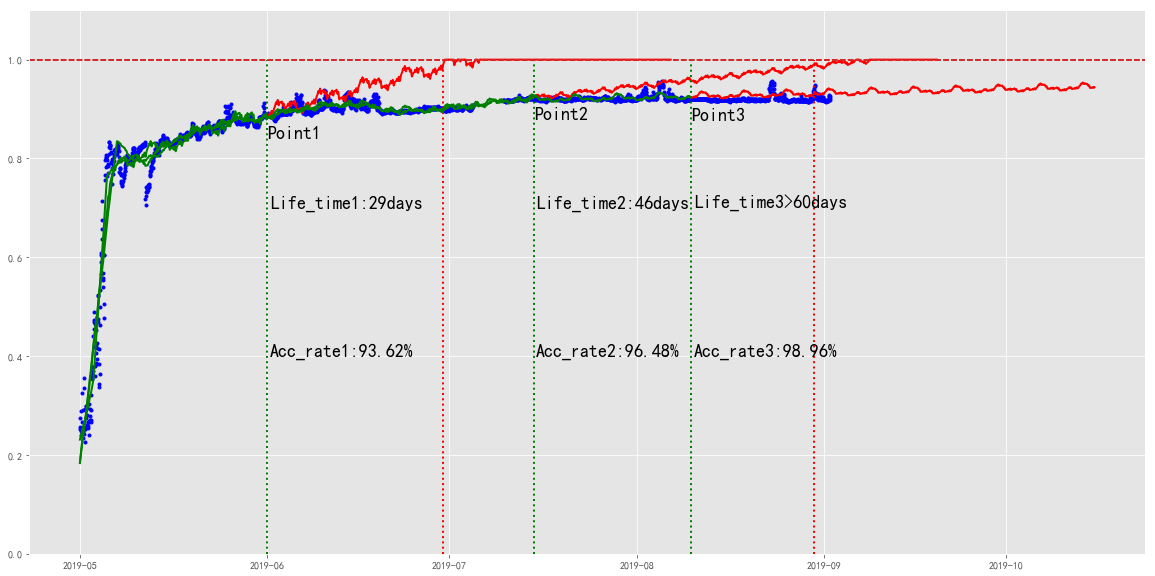

<Figure size 1440x720 with 0 Axes>

In [20]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep  2 21:01:57 2019

@author: 03010455
"""
import pandas as pd
import datetime
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib.pylab import style
from fbprophet import Prophet
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import ParameterSampler

from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics
from sklearn.externals import joblib


from matplotlib.pylab import rcParams
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
#from pyecharts import Line

#不输出警告
import warnings
warnings.filterwarnings("ignore")
import time
from datetime import datetime

day2ns=86400000000000                        #纳秒和天的转换系数
data_path=r'./data/door1_close_cv_0902.csv'
model_dir=r'saved_model_final'                #模型保存的目录

####################数据处理:CV值概率化以及筛选异常数据################
# path  数据的路径
# start_time_list: 异常点开始时间集
# end_time_list:数据结束时间
# resample:降采样频率
###################################################################

def data_process(path,start_time_list=None,end_time_list=None,resample='1H',threshold=0.1):

  # 读入数据集
    door_df = pd.read_csv(path,index_col='HAPPENTIME', parse_dates=True)
    # 数据概率化
    door_df['cv']=np.cos((door_df['cv']-threshold)*np.pi/2)  
    #降采样——1小时间隔
    door_df=door_df['cv'].resample(resample).mean()   
    door_df=door_df.fillna(method="ffill")

     # prophet模型 输入时间标签:ds  值标签:y
    data={'ds':door_df.index,'y':door_df.values}
    door_df=pd.DataFrame(data)
    
    # 将2019.7.5 到2019.7.10的数据设为缺失 （异常值）
    if len(start_time_list)==len(end_time_list):
        for start_time,end_time in zip(start_time_list, end_time_list):
            start_dt=datetime.strptime(start_time,"%Y-%m-%d")
            end_dt=datetime.strptime(end_time,"%Y-%m-%d")
            door_df.loc[(door_df['ds'] > start_dt) & (door_df['ds'] < end_dt), 'y'] = None
    return door_df


def get_cv_param(df,horizon_ratio,period_ratio,initial_ratio):
    num=df.shape[0]
    cv_param={'horizon':int(num*horizon_ratio),'period':int(num*period_ratio),'initial':int(num*initial_ratio)}
    return cv_param

##############################利用交叉验证评估效果#################
# param    模型参数
# horizon: 预测水平
# period:  数据划分间隔
# initial: 用于训练的数据
###################################################################
def ts_evaluation(df,param,horizon=None,period=None,initial=None):
    '''
    利用交叉验证评估效果   
    '''
    #param={'holidays':holidays,'growth':'linear','seasonality_prior_scale':50,'holidays_prior_scale':20}
    m=Prophet(**param)
    m.fit(df)

    df_cv = cross_validation(m, horizon='{} hours'.format(horizon), period='{} hours'.format(period), initial='{} hours'.format(initial))
    mape=np.mean(np.abs((df_cv['y'] - df_cv['yhat']) / df_cv['y']))
    rmse=np.sqrt(np.mean((df_cv['y'] - df_cv['yhat'])**2))
    scores={'mape':mape,'rmse':rmse}
    return m,df_cv,scores

##############################交叉验证训练#########################
# param_grid 模型参数
# cv_param: 交叉验证参数
# RandomizedSearch: 是否随机搜索参数
###################################################################
def ts_grid_search(df,param_grid=None,cv_param=None,RandomizedSearch=True,random_state=None,iter_num=3):

    df=df.copy()
    if param_grid is None:
        param_grid={
        'growth':['linear']   # logistic
        ,'seasonality_prior_scale':np.round(np.logspace(0,2.2,10))
        ,'holidays_prior_scale':np.round(np.logspace(0,2.2,10))
        ,'changepoint_prior_scale':[0.005,0.01,0.02,0.03,0.05,0.008,0.10,0.13,0.16,0.18,0.2]
        }
    if RandomizedSearch:
        param_list=list(ParameterSampler(param_grid,n_iter=iter_num,random_state=random_state))
    else:
        param_list=list(ParameterGrid(param_grid))

    if cv_param is None:
        cv_param={'horizon':0.2,'period':0.05,'initial':0.6}

    scores=[]
    models=[]
    df_cv_list=[]
    for i,param in enumerate(param_list):
#         if (i+1)%5==0:
#             print('{}/{}:'.format(i+1,len(param_list)),param)
        model_,df_cv_,scores_tmp=ts_evaluation(df,param,**cv_param)        
        tmp=param.copy()
        tmp.update({'mape':scores_tmp['mape'],'rmse':scores_tmp['rmse']})
        scores.append(tmp)
        models.append(model_)
        df_cv_list.append(df_cv_)
        if (i+1)%5==0:
            print('mape : {:.5f}%'.format(100*scores_tmp['mape']))
    scores=pd.DataFrame(scores)
    min_index=scores['mape'].argmin()
    best_param_=scores.loc[min_index,:].to_dict()
    best_model=models[min_index]
    best_df_cv=df_cv_list[min_index]
    best_scores_=best_param_['mape']
    best_param_.pop('mape')
    best_param_.pop('rmse')
    return best_model,best_df_cv,best_param_,best_scores_,scores

#保存模型
def save_result(df,cv_param,dt):
    best_model,best_df_cv,best_param_,best_scores_,scores=ts_grid_search(df,cv_param=cv_param,iter_num=10)
    joblib.dump(best_model, model_dir+'/phet_{}.pkl'.format(dt))    
    return best_model,best_df_cv,best_param_,best_scores_,scores

# 恢复保存的模型
def restore(model_dir,dt):
    phet_model = joblib.load(model_dir+'/phet_{}.pkl'.format(dt))
    return phet_model


##############################模型预测及效果评估#####################
# door_df_all 门CV值
# door_df_train: CV值训练集
# model: 训练好的模型
#hours:交叉验证切片的小时数
###################################################################
def calc_erro(ax,door_df_all,door_df_train,model,hours,i):
    future = model.make_future_dataframe(periods=hours,freq='H')
    fcst =model.predict(future)
    
    fcst.loc[fcst.yhat>=1,'yhat'] =1
    num_predict=len(door_df_all)-len(door_df_train)
    num_points=min(hours,num_predict)

    y_pred=fcst["yhat"][len(door_df_train):(len(door_df_train)+num_points)]
    y_true=door_df_all["y"][len(door_df_train):(len(door_df_train)+num_points)]
    y_true=y_true.fillna(y_true.mean())
    
    fcst_df=fcst.iloc[len(door_df_train):(len(door_df_train)+num_points),:]

    try:
        end_time=fcst_df[fcst_df["yhat"]>0.99]["ds"].values[0]
        index=fcst[fcst["yhat"]>0.99].index[0]
        time1=fcst.iloc[len(door_df_train),:]["ds"]
        deta_time=(end_time-np.datetime64(time1))*1.0/day2ns
        ax.text(fcst.ds.values[-hours+10],0.7,"Life_time{0}:{1}days".format(i,deta_time),size=18)
        line4=ax.plot([fcst.ds[index],fcst.ds[index]],[0,1],'r:',lw=2)
    except:
        ax.text(fcst.ds.values[-hours+10],0.7,"Life_time{0}>{1}days".format(i,60),size=18)
   
    line1=ax.plot(fcst.ds[:-hours],fcst.yhat[:-hours],'g-',lw=2)
    line2=ax.plot(fcst.ds[-hours:],fcst.yhat[-hours:],'r-',lw=2)
    line3=ax.plot([fcst.ds[len(door_df_train)],fcst.ds[len(door_df_train)]],[0,1],'g:',lw=2)
    text_point=ax.text(fcst.ds.values[len(door_df_train)],fcst.yhat[len(door_df_train)]*0.95,"Point{0}".format(i),size=18)
    
    plt.axhline(y=1, color='#d62728',linestyle='--')#画横线
    
    if len(y_pred)==len(y_true):
        predict_erro=mean_absolute_error(y_true,y_pred)
        predict_erro=100-round(predict_erro*100,2)
        text1=ax.text(fcst.ds.values[-hours+10],0.4,"Acc_rate{0}:{1}%".format(i,predict_erro),size=18)
        
    plt.ylim((0,1.1))



if __name__ == "__main__":
    #训练1
#    dates=[dt.strftime("%Y-%m-%d") for dt in pd.date_range('2019-06-01','2019-08-12',freq='4D')]
    dates=['2019-06-01','2019-07-15','2019-08-10']   # 三个模型训练的截止时间
    start_time='2019-05-01'
    end_time='2019-9-2'
    
    #异常点开始时间集合
    time_start_list=['2019-07-05']
    #异常点结束时间集合
    time_end_list=['2019-07-10']
    
    #降采样频率
    resample='1H'
    
    ax1 = plt.figure().add_subplot(1,1,1) 
    door_df_all=data_process(data_path,time_start_list,time_end_list,)
    door_df=door_df_all.loc[(door_df_all['ds'] > start_time) & (door_df_all['ds'] < end_time), :] 
    ax1.plot_date(door_df.ds,door_df.y,fmt='b.')    
    total_hours=1600 

    scores_list=[]
    best_scores_list=[]
    best_param_list=[]
    best_df_cv_list=[]
    best_model_list=[]
    lines=[]
    for i,dt in enumerate(dates):
#        door_df=data_process(data_path,'2019-05-01',dt,'1H')
        door_df_train=door_df.loc[(door_df['ds'] > '2019-05-01') & (door_df_all['ds'] <dt), :] 
        cv_param=get_cv_param(door_df,0.2,0.05,0.6)
#         best_model,best_df_cv,best_param_,best_scores_,scores=save_result(door_df,cv_param,dt) #训练模型
#         scores_list.append(scores)
#         best_scores_list.append(best_scores_)
#         best_df_cv_list.append(best_df_cv)
#         best_model_list.append(best_model)
#         best_param_list.append(best_param_)
        best_model=restore(model_dir,dt)  
        calc_erro(ax1,door_df,door_df_train,best_model,total_hours,i+1)       
#        door_df_all["ds"]>=fcst["ds"][-total_hours]     
    plt.show()
    plt.savefig("./img/predict_{}.png".format(1))

In [8]:
door_df.head()

,ds,y
2294,2019-05-01 01:00:00,0.257179
2295,2019-05-01 02:00:00,0.252415
2296,2019-05-01 03:00:00,0.274048
2297,2019-05-01 04:00:00,0.247921
2298,2019-05-01 05:00:00,0.288026


In [31]:
#训练后
for i in range(3):
    print("第{}次训练的scores\n\n".format(i+1),scores_list[i])
    print("第{}次训练的best scores\n\n".format(i+1),best_scores_list[i])
    print("第{}次训练的best_param\n\n".format(i+1),best_param_list[i])

第1次训练的scores

    changepoint_prior_scale  growth  holidays_prior_scale      mape      rmse  \
0                    0.008  linear                  10.0  0.031710  0.033987   
1                    0.160  linear                  51.0  0.027089  0.029627   
2                    0.130  linear                  17.0  0.025423  0.027511   
3                    0.050  linear                  51.0  0.027565  0.029360   
4                    0.008  linear                   1.0  0.034961  0.037739   
5                    0.200  linear                   3.0  0.028664  0.031318   
6                    0.020  linear                 158.0  0.025678  0.025671   
7                    0.100  linear                   5.0  0.028494  0.029771   
8                    0.005  linear                  90.0  0.140977  0.132826   
9                    0.200  linear                  51.0  0.028124  0.030749   

   seasonality_prior_scale  
0                      1.0  
1                      2.0  
2                

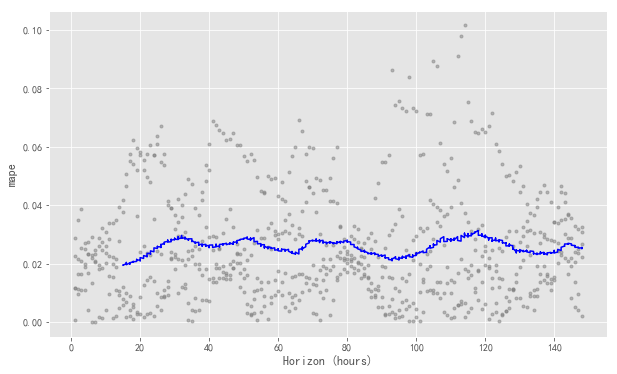

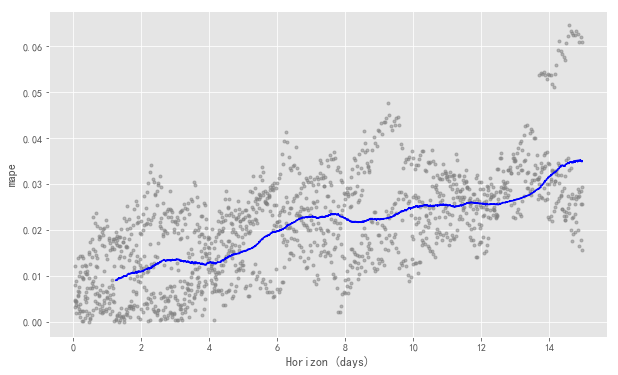

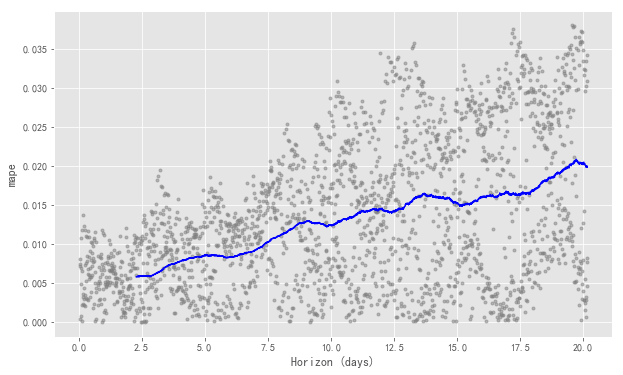

In [29]:

from fbprophet.plot import plot_cross_validation_metric
for i in range(3):
    fig = plot_cross_validation_metric(best_df_cv_list[i], metric='mape')
    plt.savefig("./img/MAPE_{}.png".format(i))